# Keras for Text Classification

**Learning Objectives**
1. Learn how to create a text classification datasets using BigQuery
1. Learn how to tokenize and integerize a corpus of text for training in Keras
1. Learn how to do one-hot-encodings in Keras
1. Learn how to use embedding layers to represent words in Keras
1. Learn about the bag-of-word representation for sentences
1. Learn how to use DNN/CNN/RNN model to classify text in keras

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.


In [2]:
import os

from google.cloud import bigquery
import pandas as pd

In [3]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [5]:
PROJECT = ""  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [5]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.16rows/s]


,url,title,score
0,https://www.kickstarter.com/projects/carlosxcl...,"Show HN: Code Cards, Like Texas hold 'em for p...",11
1,http://vancouver.en.craigslist.ca/van/roo/2035...,Best Roommate Ad Ever,11
2,https://github.com/Groundworkstech/Submicron,Deep-Submicron Backdoors,11
3,http://empowerunited.com/,Could this be the solution for the 99%?,11
4,http://themanufacturingrevolution.com/braun-vs...,Braun vs. Apple: Is copying designs theft or i...,11
5,https://github.com/styleguide/,"GitHub Styleguide - CSS, HTML, JS, Ruby",11
6,http://zoomzum.com/10-best-firefox-add-ons-to-...,Essential Firefox Add-Ons to Make You More Pro...,11
7,http://www.zintin.com,Feedback on our social media iPhone app,11
8,http://founderdating.com/comingtodinner/,Guess Who’s Coming to Dinner…To Save Our Company,11
9,http://tech.matchfwd.com/poor-mans-template-ab...,Poor Man's Template A/B Testing (in Django),11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [6]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Downloading: 100%|██████████| 100/100 [00:01<00:00, 70.48rows/s]


,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
95,f5,1254
96,gamasutra,1249
97,cnbc,1229
98,indiatimes,1223


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [7]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [8]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,feminist-software-foundation complains about r...,github
1,expose sps as web services on the fly.,github
2,show hn scrwl shorthand code reading and wr...,github
3,geoip module on nodejs now is a c addon,github
4,show hn linuxexplorer,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [9]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [10]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [11]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [12]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [13]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        368
techcrunch    339
nytimes       293
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [14]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [15]:
sample_title_dataset.head()

,title,source
88262,developerauction gets developers paid what the...,techcrunch
23052,dns over http,github
67724,very fresh perspective on the real time web,techcrunch
72303,at t restores access to 4chan,techcrunch
58674,pentagon studies reveal major nuclear problems,nytimes


In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    LSTM,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2021-08-03 14:14:14.531789: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2.3.3


In [2]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [3]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [4]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,wpilot - websocket html5 real time multiplayer...,github
1,dockerboot boot your machine with a fig.yml a...,github
2,david pogue s take on windows 7,nytimes
3,a haml-inspired mini-language for jquery jabs,github
4,commuting s hidden cost,nytimes


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [6]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[23705, 1714, 220, 128, 79, 2415, 114],
 [23706, 3330, 15, 322, 10, 2, 8577, 13948, 7, 265],
 [1018, 1989, 8, 219, 9, 179, 255]]

In [7]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [8]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [9]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

In [10]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [11]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[23705,  1714,   220,   128,    79,  2415,   114,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [23706,  3330,    15,   322,    10,     2,  8577, 13948,     7,
          265,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1018,  1989,     8,   219,     9,   179,   255,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [12]:
titles_df.source[:4]

0     github
1     github
2    nytimes
3     github
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [13]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [14]:
# TODO 2
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [15]:
encode_labels(titles_df.source[:4])

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [16]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [17]:
sources_train.value_counts()

github        29221
techcrunch    24659
nytimes       23082
Name: source, dtype: int64

In [18]:
sources_valid.value_counts()

github        7304
techcrunch    6232
nytimes       5705
Name: source, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [19]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [20]:
X_train[:3]

array([[23705,  1714,   220,   128,    79,  2415,   114,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [23706,  3330,    15,   322,    10,     2,  8577, 13948,     7,
          265,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1018,  1989,     8,   219,     9,   179,   255,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [21]:
Y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [30]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]), # TODO 3
        Lambda(lambda x: tf.reduce_mean(x, axis=1)), # TODO 4
        Dense(N_CLASSES, activation='softmax') # TODO 5
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

2021-08-03 14:03:43.403057: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:03:43.403367: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/100
 27/257 [==>...........................] - ETA: 1s - loss: 1.0940 - accuracy: 0.3615

2021-08-03 14:03:43.797931: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:03:43.831940: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-08-03 14:03:43.832870: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 71 callback api events and 71 activity events. 
2021-08-03 14:03:43.837736: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/dnn/train/plugins/profile/2021_08_03_14_03_43
2021-08-03 14:03:43.839835: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./text_models/dnn/train/plugins/profile/2021_08_03_14_03_43/tensorflow-2-3-20210802-113839.trace.json.gz
2021-08-03 14:03:43.844439: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/dnn/train/plugins/profile/2021_08_03_14_03_43
2021-08-03 14:03:43.845128: I tenso

257/257 [==============================] - 1s 5ms/step - loss: 1.0479 - accuracy: 0.4262 - val_loss: 0.9783 - val_accuracy: 0.5423
Epoch 2/100
257/257 [==============================] - 1s 5ms/step - loss: 0.8883 - accuracy: 0.6849 - val_loss: 0.8044 - val_accuracy: 0.7543
Epoch 3/100
257/257 [==============================] - 1s 5ms/step - loss: 0.7340 - accuracy: 0.7843 - val_loss: 0.6807 - val_accuracy: 0.7946
Epoch 4/100
257/257 [==============================] - 1s 5ms/step - loss: 0.6244 - accuracy: 0.8142 - val_loss: 0.5936 - val_accuracy: 0.8116
Epoch 5/100
257/257 [==============================] - 1s 5ms/step - loss: 0.5440 - accuracy: 0.8306 - val_loss: 0.5318 - val_accuracy: 0.8195
Epoch 6/100
257/257 [==============================] - 1s 5ms/step - loss: 0.4853 - accuracy: 0.8424 - val_loss: 0.4883 - val_accuracy: 0.8291
Epoch 7/100
257/257 [==============================] - 1s 5ms/step - loss: 0.4416 - accuracy: 0.8532 - val_loss: 0.4569 - val_accuracy: 0.8354
Epoch 8/100

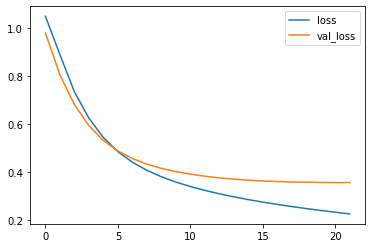

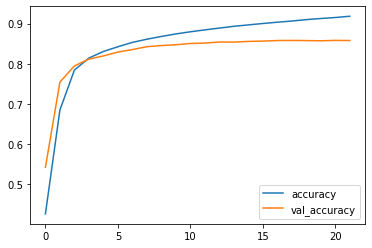

In [31]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [26]:
def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True), # TODO 3
        LSTM(units), # TODO 5
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

2021-08-03 14:17:21.486648: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:17:21.486828: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/100
  8/257 [..............................] - ETA: 5s - loss: 1.0982 - accuracy: 0.3654 

2021-08-03 14:17:24.876840: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:17:24.973355: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-08-03 14:17:24.975269: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 326 callback api events and 326 activity events. 
2021-08-03 14:17:24.987559: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/rnn/train/plugins/profile/2021_08_03_14_17_24
2021-08-03 14:17:24.992367: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./text_models/rnn/train/plugins/profile/2021_08_03_14_17_24/tensorflow-2-3-20210802-113839.trace.json.gz
2021-08-03 14:17:25.002766: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/rnn/train/plugins/profile/2021_08_03_14_17_24
2021-08-03 14:17:25.004227: I ten

257/257 [==============================] - 4s 14ms/step - loss: 1.0901 - accuracy: 0.3830 - val_loss: 1.0750 - val_accuracy: 0.3809
Epoch 2/100
257/257 [==============================] - 3s 10ms/step - loss: 0.9973 - accuracy: 0.5091 - val_loss: 0.8625 - val_accuracy: 0.6362
Epoch 3/100
257/257 [==============================] - 3s 10ms/step - loss: 0.7698 - accuracy: 0.6459 - val_loss: 0.7132 - val_accuracy: 0.6551
Epoch 4/100
257/257 [==============================] - 3s 10ms/step - loss: 0.6729 - accuracy: 0.6848 - val_loss: 0.6595 - val_accuracy: 0.6709
Epoch 5/100
257/257 [==============================] - 3s 10ms/step - loss: 0.6252 - accuracy: 0.6820 - val_loss: 0.6301 - val_accuracy: 0.6888
Epoch 6/100
257/257 [==============================] - 3s 10ms/step - loss: 0.5931 - accuracy: 0.7096 - val_loss: 0.6091 - val_accuracy: 0.7087
Epoch 7/100
257/257 [==============================] - 3s 10ms/step - loss: 0.5679 - accuracy: 0.7315 - val_loss: 0.5916 - val_accuracy: 0.7243
Epoc

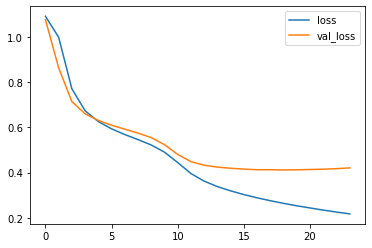

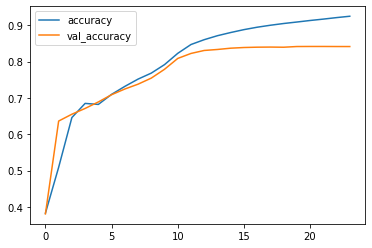

In [27]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 5

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [28]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(
            VOCAB_SIZE + 1,
            embed_dim,
            input_shape=[MAX_LEN],
            mask_zero=True), # TODO 3
        Conv1D( # TODO 5
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),
        Flatten(), # TODO 5
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



2021-08-03 14:19:01.722475: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:19:01.722672: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/100
 18/257 [=>............................] - ETA: 2s - loss: 1.0978 - accuracy: 0.3593

2021-08-03 14:19:03.422022: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-03 14:19:03.496354: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-08-03 14:19:03.497459: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 81 callback api events and 81 activity events. 
2021-08-03 14:19:03.503034: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/cnn/train/plugins/profile/2021_08_03_14_19_03
2021-08-03 14:19:03.505359: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./text_models/cnn/train/plugins/profile/2021_08_03_14_19_03/tensorflow-2-3-20210802-113839.trace.json.gz
2021-08-03 14:19:03.510868: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./text_models/cnn/train/plugins/profile/2021_08_03_14_19_03
2021-08-03 14:19:03.511599: I tenso

257/257 [==============================] - 2s 7ms/step - loss: 1.0795 - accuracy: 0.4002 - val_loss: 1.0395 - val_accuracy: 0.4829
Epoch 2/100
257/257 [==============================] - 2s 6ms/step - loss: 0.9209 - accuracy: 0.5834 - val_loss: 0.7836 - val_accuracy: 0.6525
Epoch 3/100
257/257 [==============================] - 2s 6ms/step - loss: 0.6885 - accuracy: 0.6843 - val_loss: 0.6284 - val_accuracy: 0.7015
Epoch 4/100
257/257 [==============================] - 2s 6ms/step - loss: 0.5811 - accuracy: 0.7323 - val_loss: 0.5670 - val_accuracy: 0.7467
Epoch 5/100
257/257 [==============================] - 2s 6ms/step - loss: 0.5201 - accuracy: 0.7757 - val_loss: 0.5221 - val_accuracy: 0.7757
Epoch 6/100
257/257 [==============================] - 2s 6ms/step - loss: 0.4674 - accuracy: 0.8096 - val_loss: 0.4826 - val_accuracy: 0.8011
Epoch 7/100
257/257 [==============================] - 2s 6ms/step - loss: 0.4211 - accuracy: 0.8334 - val_loss: 0.4515 - val_accuracy: 0.8144
Epoch 8/100

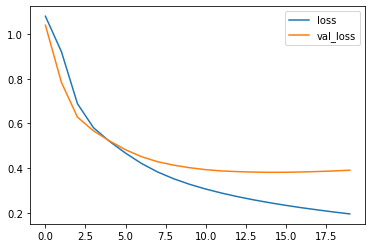

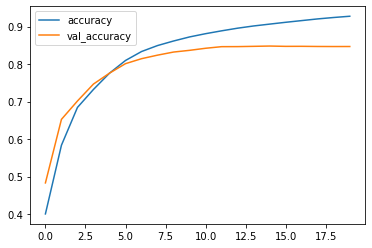

In [29]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 5


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License